## Audio Analysis of Elephant rumbles

Here we are looking for best way to reppresent an elephant rumble spectrogram for deeplearning

In [2]:
# load stuff we need
import json
import logging
import os
import time
import warnings
import librosa
import numpy as np
import pandas as pd
import pydub
import sklearn.preprocessing

from tqdm import tqdm

import h5py as h5py

from config import *

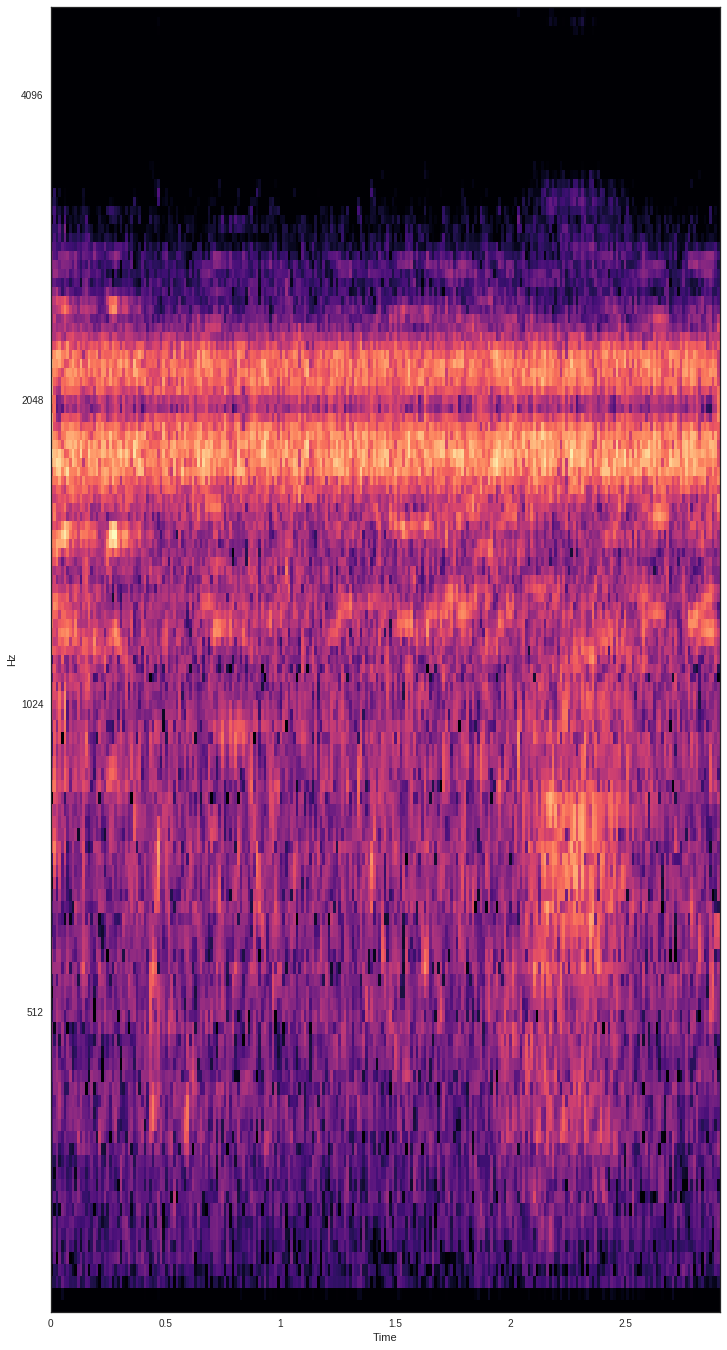

In [86]:
# load wav file
# setup and prepare audio files
np.random.seed(1)

#filename = "EFAF2011A008-38.WAV"
filename = "sel-02-20151005-000114.80.wav"
category = "rumble"

# overrule settings in config
SAMPLING_RATE = 44100  # Audio sampling rate, other parameters are hand-tuned for 44.1 kHz
CHUNK_SIZE = 882  # Spectrogram hop_size, 882 samples @ 44.1 kHz = 20 ms
FFT_SIZE = 2 * CHUNK_SIZE  # Spectrogram FFT window length

MEL_BANDS = 128  # 80 Number of mel frequency bands
MEL_FREQS = librosa.core.mel_frequencies(n_mels=MEL_BANDS)
#MEL_BANDS = 25
#MEL_FREQS = MEL_FREQS[0:25]

# current processing of the audio files
# default serval location
#audio_file = './dataset/audio/' + filename

# temp cornel location

audio_file = '../../data/cornell/elephant-listening/20151005/' + filename
spec_file = './dataset/tmp/' + filename + '.spec.npy'

audio = pydub.AudioSegment.from_file(audio_file).set_frame_rate(SAMPLING_RATE).set_channels(1)
audio = (np.fromstring(audio._data, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float

spec = librosa.feature.melspectrogram(audio, SAMPLING_RATE, n_fft=FFT_SIZE, fmin=0, fmax = 5000, 
                                      hop_length=CHUNK_SIZE, n_mels=MEL_BANDS) # MEL_BANDS
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # Ignore log10 zero division
    spec = librosa.core.perceptual_weighting(spec, MEL_FREQS, amin=1e-5, ref_power=1e-5,
                                             top_db=None)

spec = np.clip(spec, 0, 100)
#np.save(spec_file, spec.astype('float16'), allow_pickle=False)

librosa.display.specshow(spec,
                          y_axis='mel', sr=44100, fmin=0, fmax = 5000,
                          x_axis='time')


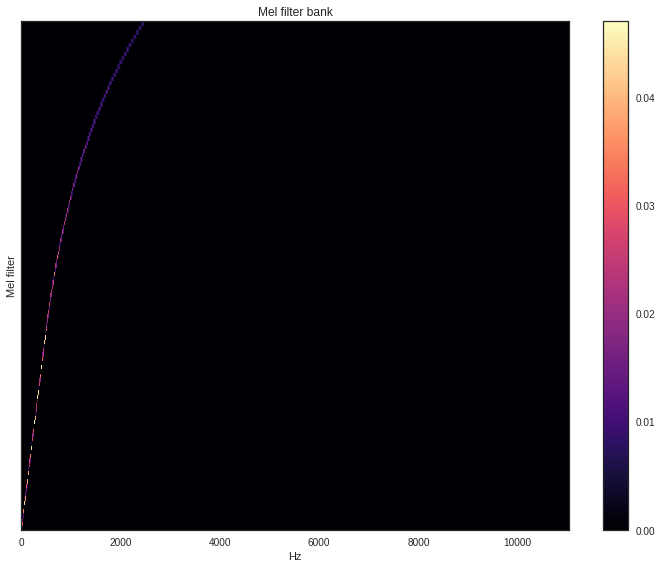

In [82]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10.0, 8.0]

# play around with mel filterbank
melfb = librosa.filters.mel(sr=44100,n_fft=FFT_SIZE, n_mels=MEL_BANDS, fmin=0, fmax=5000)

import matplotlib.pyplot as plt
plt.figure()
librosa.display.specshow(melfb, x_axis='linear')
plt.ylabel('Mel filter')
plt.title('Mel filter bank')
plt.colorbar()
plt.tight_layout()

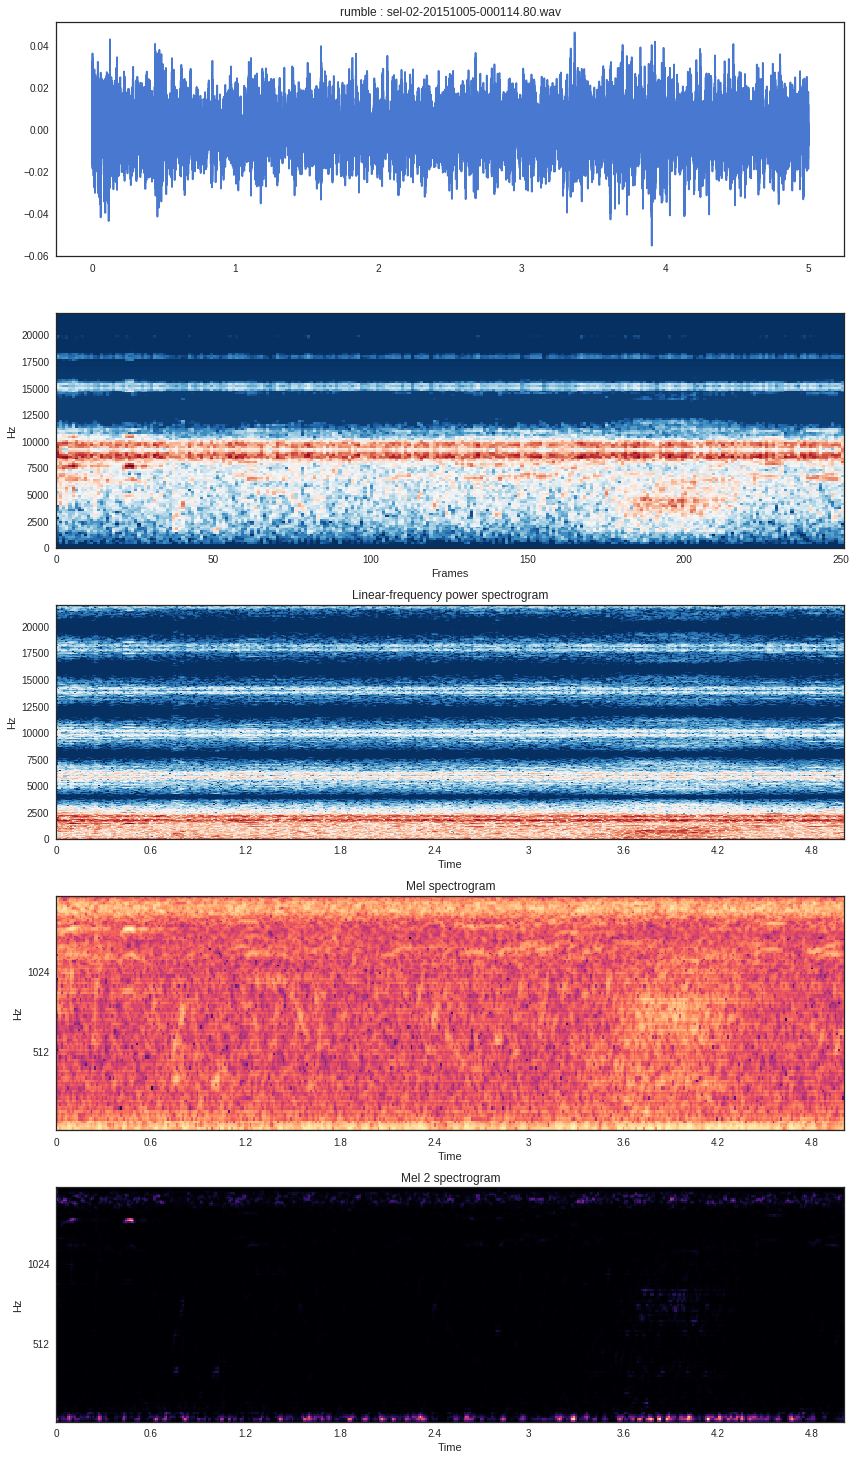

In [83]:
# You can reload this cell to get a different clip at every try
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# bigger figure size
matplotlib.rcParams['figure.figsize'] = [12.0, 24.0] # default : [6.0, 4.0]

import librosa.display

import IPython.display

#all_recordings = glob.glob('ESC-50/*/*.ogg')
#clip = Clip(all_recordings[random.randint(0, len(all_recordings) - 1)])    

plt.subplot(6, 1, 1)
plt.title('{0} : {1}'.format( category, filename))
plt.plot(np.arange(0, len(audio)) / 44100.0, audio)

plt.subplot(6, 1, 2)
librosa.display.specshow(spec, sr=44100, x_axis='frames', y_axis='linear', cmap='RdBu_r')

# linear spectrogram
plt.subplot(6, 1, 3)
D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)
librosa.display.specshow(D, sr=44100, y_axis='linear', x_axis='time', cmap='RdBu_r')
#plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

plt.subplot(6, 1, 4)
D = np.abs(librosa.stft(audio))**2
S = librosa.feature.melspectrogram(S=D, sr=44100, fmin=0, fmax=2000)
librosa.display.specshow(librosa.power_to_db(S,
                                              ref=np.max),
                          y_axis='mel', sr=44100, fmax=2000,
                          x_axis='time')
#plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

# log scale spectrogram
plt.subplot(6, 1, 5)
S = librosa.feature.melspectrogram(audio, sr=44100, fmin=0, fmax=2000)
librosa.display.specshow(S,
                          y_axis='mel', sr=44100, fmax=2000,
                          x_axis='time')
#plt.colorbar(format='%+2.0f dB')
plt.title('Mel 2 spectrogram')
plt.tight_layout()

    
IPython.display.Audio(filename=audio_file, rate=SAMPLING_RATE) 

## Filter attempt
Stuff below from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

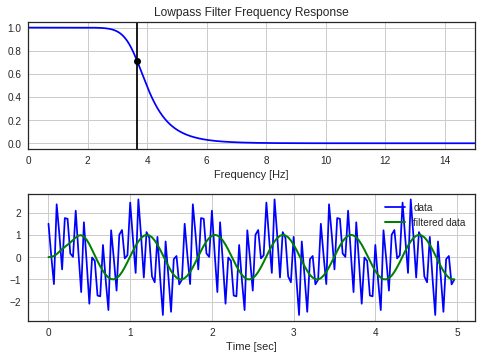

In [20]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

The main problem is that even such sub-optimal representations are very high-dimensional. Most basic classifiers will need some [dimensionality reduction](http://en.wikipedia.org/wiki/Dimensionality_reduction) applied first.

With deep learning this could be circumvented and we use the spectrum representation.

We will use [Mel-frequency cepstral coefficients](http://en.wikipedia.org/wiki/Mel-frequency_cepstrum) (*MFCC*) and [zero-crossing rate](http://en.wikipedia.org/wiki/Zero-crossing_rate) (*ZCR*) as our baseline features. ZCR is a very simple, yet useful feature, whereas MFCCs are ubiquitous in speech processing and analyzing harmonic content. They may be less suitable for more noise-like environmental sounds, but the goal here is to get a general feel for the characteristics of the dataset, without striving for maximum classification accuracy.

So, first thing worth doing is to look at the distribution of the computed baseline features.

There are multiple ways this can be done, but each visualization perspective will have to, in some manner, reduce the number of dimensions analyzed at the same time (we have multiple categories, clips per category, features per clip).

Let's begin by looking at a **single clip / all features** perspective:

In [15]:
def get_frame(audio, index):
    if index < 0:
        return None
    return audio[(index * CHUNK_SIZE):(index+1) * CHUNK_SIZE]

def compute_mfcc(audio):
    # MFCC computation with default settings (2048 FFT window length, 512 hop length, 128 bands)
    melspectrogram = librosa.feature.melspectrogram(audio, sr=SAMPLING_RATE, hop_length=CHUNK_SIZE)
    logamplitude = librosa.logamplitude(melspectrogram)
    mfcc = librosa.feature.mfcc(S=logamplitude, n_mfcc=13).transpose()
    return mfcc

def compute_zcr(audio):
    # Zero-crossing rate
    zcr = []
    frames = int(np.ceil(len(audio) / 1000.0 * CHUNK_SIZE / CHUNK_SIZE))

    for i in range(0, frames):
        frame = get_frame(audio, i)
        zcr.append(np.mean(0.5 * np.abs(np.diff(np.sign(frame)))))

    zcr = np.asarray(zcr)
    return zcr

In [18]:
def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]], axisbg='w')

/home/hugo/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/hugo/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hugo/anaconda3/envs/py35/lib/python3.5/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


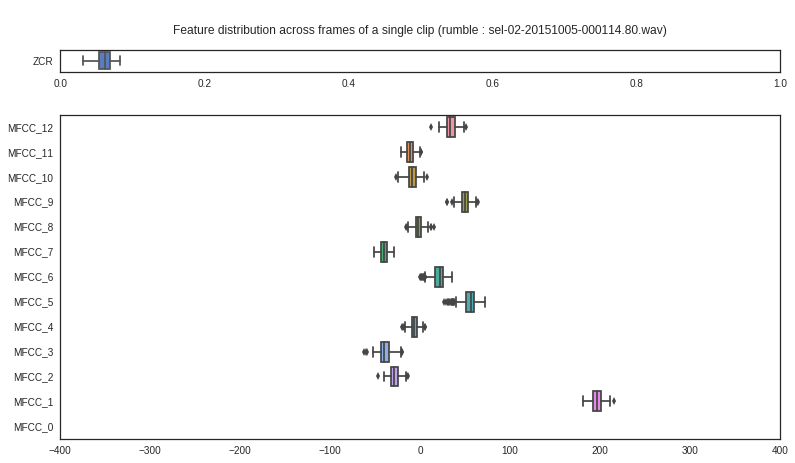

In [19]:
import seaborn as sb
sb.set(style="white", palette="muted")

def plot_single_clip(clip):
    mfcc = compute_mfcc(clip)
    zcr = compute_zcr(audio)
    col_names = list('MFCC_{}'.format(i) for i in range(np.shape(mfcc)[1]))
    MFCC = pd.DataFrame(mfcc[:, :], columns=col_names)

    f = plt.figure(figsize=(10, 6))
    ax = f.add_axes([0.0, 0.0, 1.0, 1.0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.75])
    ax_mfcc.set_xlim(-400, 400)
    ax_zcr = add_subplot_axes(ax, [0.0, 0.85, 1.0, 0.05])
    ax_zcr.set_xlim(0.0, 1.0)

    plt.title('Feature distribution across frames of a single clip ({0} : {1})'.format(category, filename), y=1.5)
    sb.boxplot(MFCC, vert=False, order=list(reversed(MFCC.columns)), ax=ax_mfcc)
    sb.boxplot(pd.DataFrame(zcr, columns=['ZCR']), vert=False, ax=ax_zcr)
    
plot_single_clip(audio)